In [308]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import yaml
from sklearn.preprocessing import MinMaxScaler, RobustScaler
%matplotlib inline


In [309]:
#load Accelerator data


# new additional data: vscode-remote://ssh-remote%2Bpc95258.slac.stanford.edu/home/sanjeev/GPT/simulation_2023-08-15_16-18-12/dump.yaml
d = yaml.safe_load(open('/home/sanjeev/GPT/simulation_2023-08-09_14-26-39/dump.yaml'))
data = pd.DataFrame(d['data'])
data.index = list(map(int, data.index))
data.sort_index(inplace=True)
print(len(data))
print(data.index)


print(len(data))



800
Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       791, 792, 793, 794, 795, 796, 797, 798, 799, 800],
      dtype='int64', length=800)
800


186
186


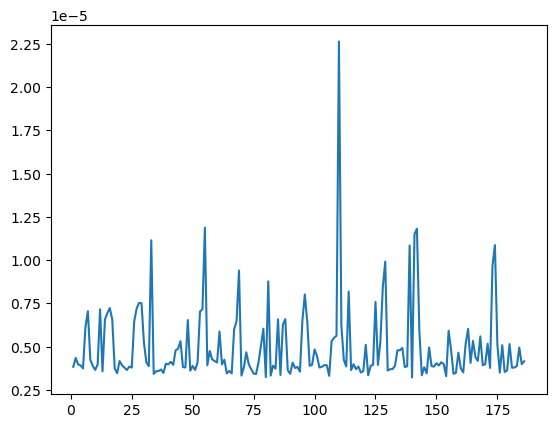

In [310]:
d2 = yaml.safe_load(open('/home/sanjeev/GPT/simulation_2023-08-16_11-18-18/dump.yaml'))
data2 = pd.DataFrame(d2['data'])
data2.index = list(map(int, data2.index))
data2.sort_index(inplace=True)

plt.plot(data2['emit_mean'])

print(len(data2))


print(len(data2))


# Adjust the index of data2 to start after the last index of data
last_index = data.index[-1]
data2.index = range(last_index + 1, last_index + 1 + len(data2))

In [311]:

data = pd.concat([data, data2])


In [312]:

data['bunch_length'] = data['bunch_length']*1e-12
data = data[data['emit_mean'] < 10e-6]


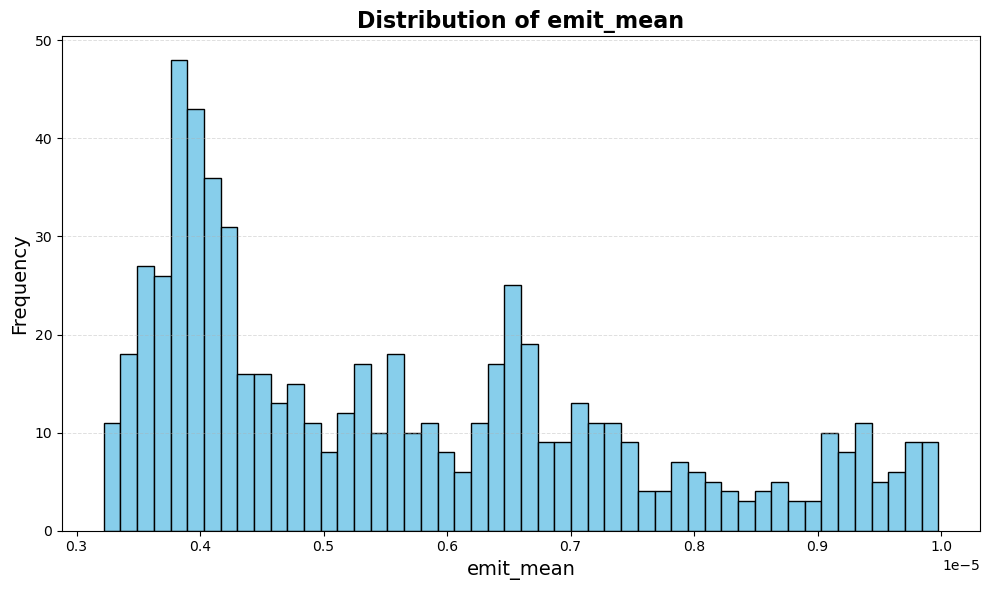

In [313]:


# Create a histogram
plt.figure(figsize=(10,6))
plt.hist(data['emit_mean'], bins=50, color='skyblue', edgecolor='black')  # 50 bins is just an example; adjust as needed

# Add title and labels
plt.title('Distribution of emit_mean', fontsize=16, fontweight='bold')
plt.xlabel('emit_mean', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.4)
plt.tight_layout()
plt.show()

In [314]:


data['laser_pulse_length'] = 4.4999e-12

data.head()
print(data['sol_var'])

# Displaying the smallest values of 'sol_var' in the filtered data
smallest_values = data['sol_var'].nsmallest(10)
smallest_values
# Dropping the specific value with index 799
data.drop(799, inplace=True, errors='ignore')

# Checking if the value has been dropped
data.loc[799] if 799 in data.index else "Value with index 799 has been dropped."

22     0.242232
25     0.245993
30     0.202653
32     0.247892
41     0.242333
         ...   
982    0.242222
983    0.242379
984    0.228790
985    0.242221
986    0.242817
Name: sol_var, Length: 651, dtype: float64


'Value with index 799 has been dropped.'

In [315]:
data.tail()

,QUAD:IN10:361:BCTRL,QUAD:IN10:371:BCTRL,QUAD:IN10:425:BCTRL,QUAD:IN10:441:BCTRL,QUAD:IN10:511:BCTRL,QUAD:IN10:525:BCTRL,alpha_x,alpha_y,beta_x,beta_y,...,gun_phase,laser_pulse_length,norm_emit_x,norm_emit_y,num_particles,sigx,sigy,sol_var,xopt_error,xopt_runtime
982,0.026691,0.151227,-0.162121,0.040909,0.281221,-0.081262,4.240447,-0.947616,61.147669,9.657527,...,270.433301,4.499900e-12,0.000004,0.000004,9979,1.009050,0.521795,0.242222,False,74.889153
983,0.034475,0.046719,-0.162121,0.040909,0.281221,-0.081262,-0.034434,0.740257,3.291148,3.023704,...,270.557615,4.499900e-12,0.000004,0.000004,9980,0.342465,0.321202,0.242379,False,74.190840
984,0.034483,0.148441,-0.144379,-0.236994,0.089808,-0.045924,-82.751306,6.496466,794.689681,407.991168,...,270.558067,4.499900e-12,0.000005,0.000005,9980,4.061610,2.807750,0.228790,False,87.874211
985,0.111965,0.155440,-0.112315,0.042456,0.285710,-0.137365,-0.002033,-70.497644,202.353104,221.708914,...,270.558068,4.499900e-12,0.000004,0.000004,9975,1.939010,2.128870,0.242221,False,102.860933
986,0.036023,0.043792,-0.163835,-0.020398,0.282253,-0.081262,-0.448797,1.092369,4.475902,2.621268,...,270.227008,4.499900e-12,0.000004,0.000004,9989,0.403269,0.299940,0.242817,False,80.454743


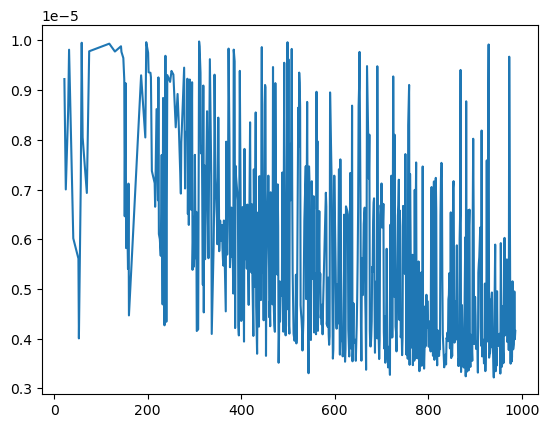

In [316]:
plt.plot(data['emit_mean'])


In [317]:
print(len(data))


650


In [318]:
dropout_var = .05


class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_var)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_var)
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_var)
        
        self.fc4 = nn.Linear(hidden_size, hidden_size) 
        self.dropout4 = nn.Dropout(dropout_var)        
        
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout1(x)
        
        x = torch.tanh(self.fc2(x))
        x = self.dropout2(x)
        
        x = torch.tanh(self.fc3(x))
        x = self.dropout3(x)
        
        x = torch.tanh(self.fc4(x))  
        x = self.dropout4(x)       
        
        x = self.fc5(x)
        
        return x


length of data is 650
 before adding augmented data - train data: 390
 after adding augmented data - train data: 780
Epoch 1 - Training loss: 0.30720069706439973 - Validation loss: 0.11758717894554138
Epoch 2 - Training loss: 0.2785005325078964 - Validation loss: 0.09904739335179329
Epoch 3 - Training loss: 0.27773700177669525 - Validation loss: 0.0947099544107914
Epoch 4 - Training loss: 0.27997578799724576 - Validation loss: 0.1101659044623375
Epoch 5 - Training loss: 0.27782392263412475 - Validation loss: 0.09939389675855637
Epoch 6 - Training loss: 0.27878217041492465 - Validation loss: 0.0990884244441986
Epoch 7 - Training loss: 0.2760582560300827 - Validation loss: 0.10143494009971618
Epoch 8 - Training loss: 0.2760068655014038 - Validation loss: 0.09426866620779037
Epoch 9 - Training loss: 0.278076052069664 - Validation loss: 0.0972559131681919
Epoch 10 - Training loss: 0.2764234268665314 - Validation loss: 0.10101087093353271
Epoch 11 - Training loss: 0.27410355150699617 - Vali

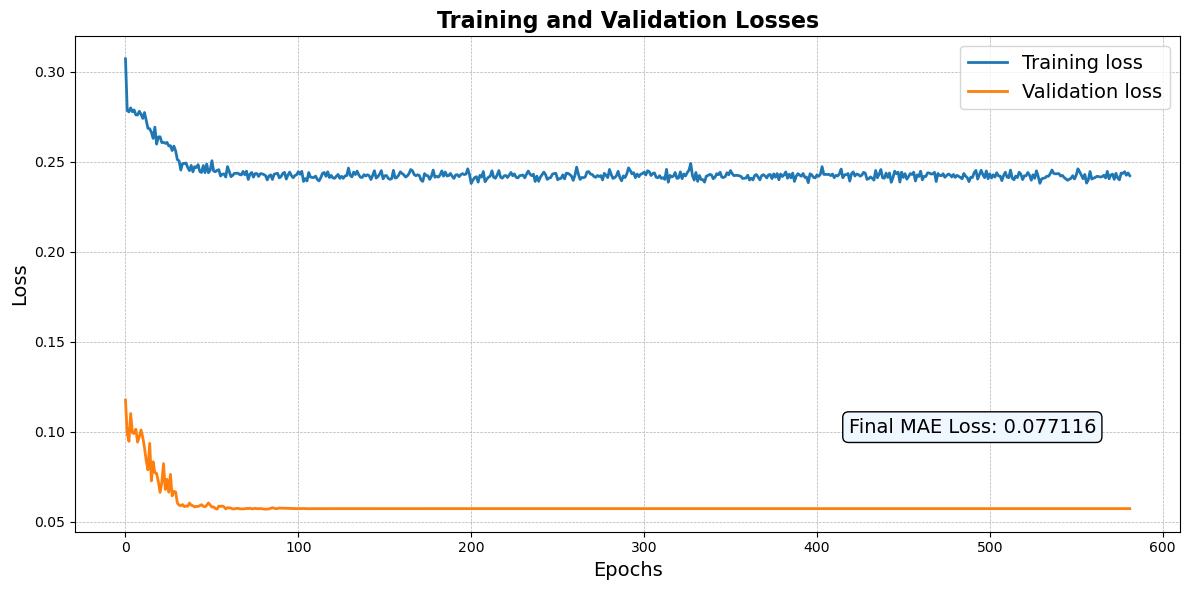

In [319]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
#load Accelerator data




# Define the features and targets
features = ['sol_var','gun_phase','bunch_charge','laser_pulse_length','QUAD:IN10:361:BCTRL','QUAD:IN10:371:BCTRL','QUAD:IN10:425:BCTRL','QUAD:IN10:441:BCTRL','QUAD:IN10:511:BCTRL','QUAD:IN10:525:BCTRL']
targets = ['emit_mean','bunch_length','norm_emit_x','norm_emit_y','sigx','sigy']

# Create separate scalers for features and targets
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()
print(f"length of data is {len(data)}")
# Fit the scalers and transform the data
data[features] = scaler_features.fit_transform(data[features])
data[targets] = scaler_targets.fit_transform(data[targets])


# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) 

# Duplicate the training data and add a small amount of noise
noise_factor = 0.5  # This can be adjusted based on the desired noise level
noisy_train_data = train_data + noise_factor * np.random.randn(*train_data.shape)
print(f" before adding augmented data - train data: {len(train_data)}")
# Combine the original training data with its noisy duplicate
train_data = pd.concat([train_data, noisy_train_data])
print(f" after adding augmented data - train data: {len(train_data)}")




# Create PyTorch Datasets and DataLoaders
batch_size = 32
train_dataset = TensorDataset(torch.tensor(train_data[features].values).float(), torch.tensor(train_data[targets].values).float())
val_dataset = TensorDataset(torch.tensor(val_data[features].values).float(), torch.tensor(val_data[targets].values).float())
test_dataset = TensorDataset(torch.tensor(test_data[features].values).float(), torch.tensor(test_data[targets].values).float())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize the network and define the loss function and the optimizer
net = Net(input_size=len(features), hidden_size=500, output_size=len(targets))
criterion = nn.L1Loss()  # Changed this line to use MAE
optimizer = optim.Adam(net.parameters(), lr=0.001)
# Add a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# Training loop with early stopping
num_epochs = 1000
patience = 500
early_stopping_counter = 0
best_loss = float('inf')

train_loss = []
val_loss = []
learning_rates_extracted = []
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    #extract data to plot learning rate    
    for param_group in optimizer.param_groups:
        learning_rates_extracted.append(param_group['lr'])    
        
    # Call the learning rate scheduler at the end of the epoch a
    scheduler.step()


    # validation part
    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    running_loss /= len(train_dataloader)
    validation_loss /= len(val_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {running_loss} - Validation loss: {validation_loss}")
    
    train_loss.append(running_loss)
    val_loss.append(validation_loss)
    
    # early stopping
    if validation_loss < best_loss:
        best_loss = validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= patience:
        print('Early stopping...')
        break

# Define the model evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    mse_loss = 0.0
    mae_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            mse_loss += criterion(outputs, labels).item() * inputs.shape[0]
            mae_loss += torch.nn.L1Loss()(outputs, labels).item() * inputs.shape[0]
            n_samples += inputs.shape[0]
    mse_loss /= n_samples
    rmse_loss = sqrt(mse_loss)
    mae_loss /= n_samples
    return mse_loss, rmse_loss, mae_loss

# Evaluate the model on the test data
mse_loss, rmse_loss, mae_loss = evaluate_model(net, test_dataloader)
print(f'MSE Loss: {mse_loss:.6f}, RMSE Loss: {rmse_loss:.6f}, MAE Loss: {mae_loss:.6f}')

# After training, we'll plot the training and validation loss
plt.figure(figsize=(12,6))

# Plot the training and validation losses
plt.plot(train_loss, label='Training loss', linewidth=2)  # Increase linewidth for better visibility
plt.plot(val_loss, label='Validation loss', linewidth=2)

# Add legend, title, and labels
plt.legend(fontsize=14)
plt.title('Training and Validation Losses', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Display final MAE loss on the plot
plt.annotate(f'Final MAE Loss: {mae_loss:.6f}', 
             xy=(0.7, 0.2), 
             xycoords='axes fraction', 
             fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

# Enhancements for better aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Dashed grid lines
plt.tight_layout()  # Adjust subplot parameters to give specified padding

plt.show()


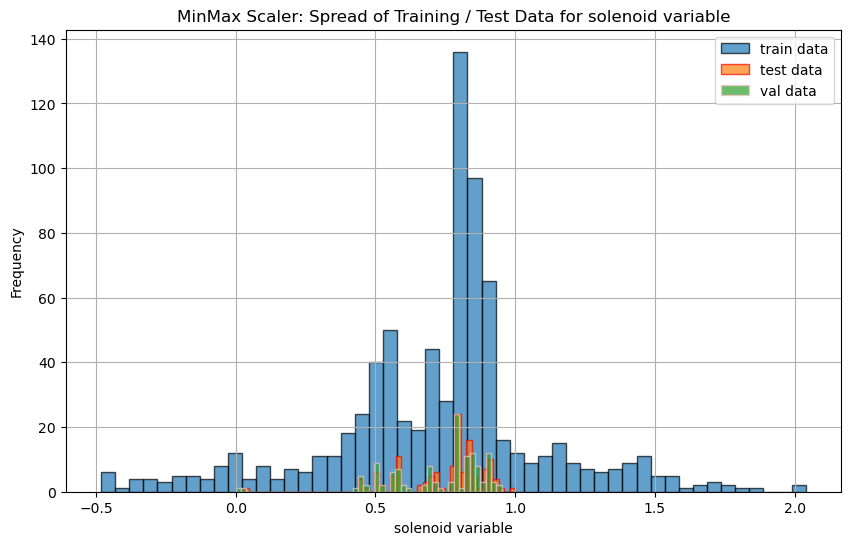

In [320]:
# Extracting 'sol_var' column from the train_data DataFrame
sol_var_data_train = train_data['sol_var']
sol_var_data_test = test_data['sol_var']
sol_var_data_val = val_data['sol_var']
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sol_var_data_train, label="train data", bins=50, edgecolor='black', alpha=0.7)
plt.hist(sol_var_data_test,label="test data", bins=50, edgecolor='red', alpha=0.7)
plt.hist(sol_var_data_val,label="val data", bins=50, edgecolor='pink', alpha=0.7)


plt.title('MinMax Scaler: Spread of Training / Test Data for solenoid variable')
plt.xlabel('solenoid variable')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

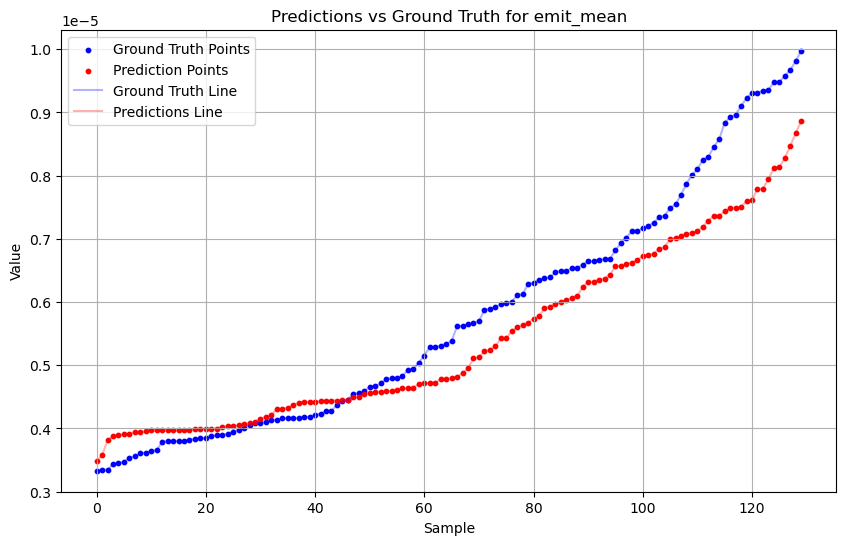

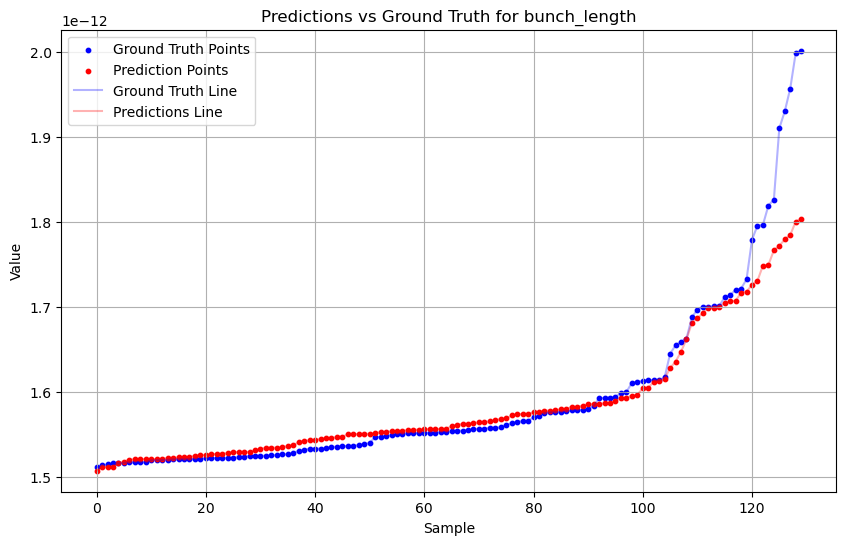

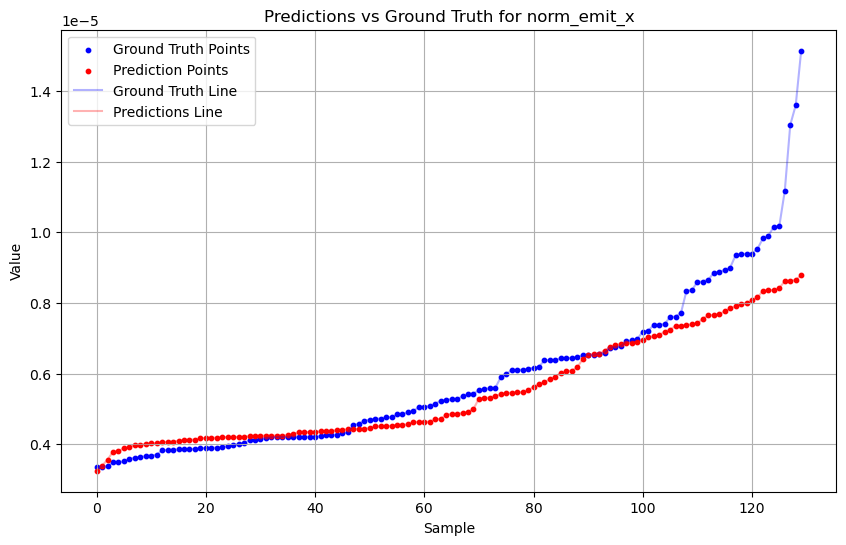

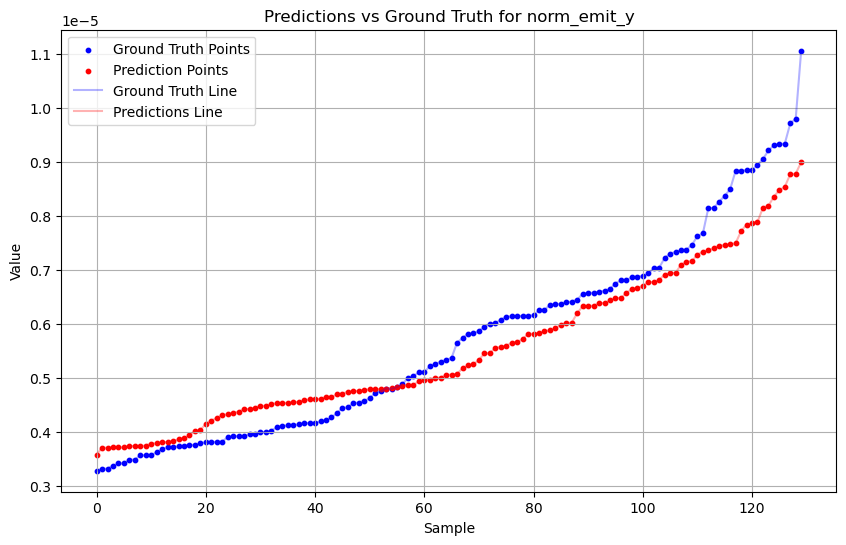

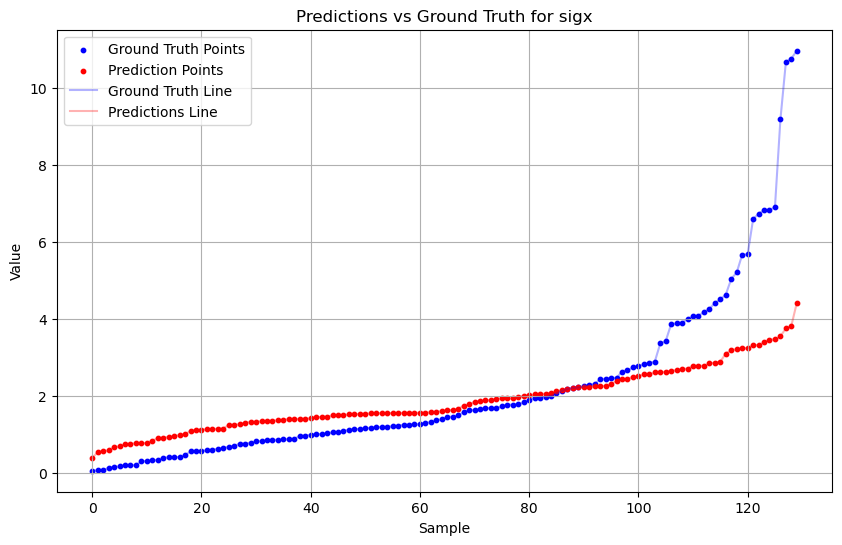

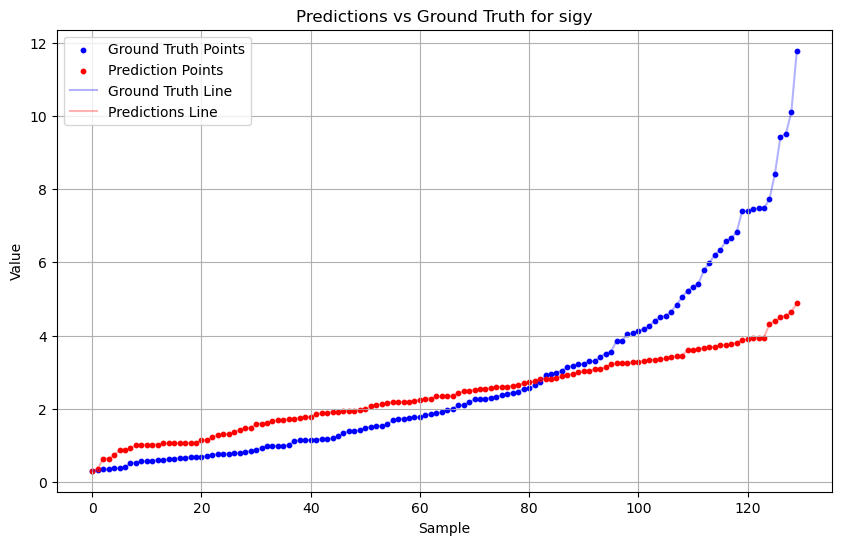

In [321]:
import numpy as np

# Generate predictions for test set
net.eval()
with torch.no_grad():
    predictions = net(torch.tensor(test_data[features].values).float())

# Convert the tensor to a numpy array
predictions = predictions.numpy()
predictions = scaler_targets.inverse_transform(predictions)
actual_data = scaler_targets.inverse_transform(test_data[targets].values)

# Create a dataframe of predictions
pred_df = pd.DataFrame(predictions, columns=targets, index=test_data.index)
test_data = pd.DataFrame(actual_data, columns=targets, index=test_data.index)

# Select targets to plot
targets_to_plot = targets

for target in targets_to_plot:
    # Sort the ground truth and predictions by the magnitude of the predictions
    sorted_test_data = test_data.sort_values(by=target)
    sorted_pred_df = pred_df.sort_values(by=target)

    # Plot the ground truth and predictions
    plt.figure(figsize=(10, 6))
    
    # Scatter plots
    plt.scatter(range(len(sorted_test_data)), sorted_test_data[target].values, s=10, color='blue', label='Ground Truth Points')
    plt.scatter(range(len(sorted_pred_df)), sorted_pred_df[target].values, s=10, color='red', label='Prediction Points')

    # Line plots
    plt.plot(sorted_test_data[target].values, label='Ground Truth Line', color='blue', alpha=0.3)
    plt.plot(sorted_pred_df[target].values, label='Predictions Line', color='red', alpha=0.3)
    
    plt.title(f"Predictions vs Ground Truth for {target}")
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

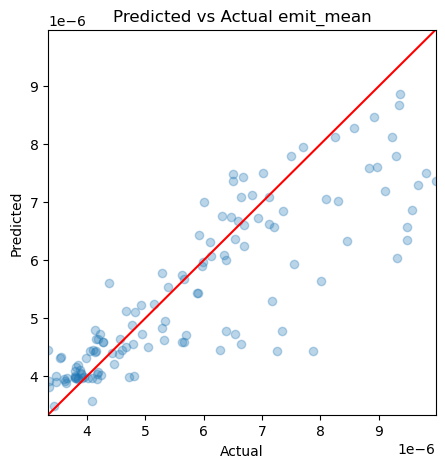

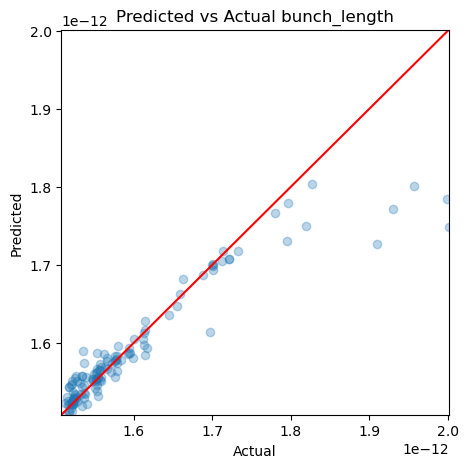

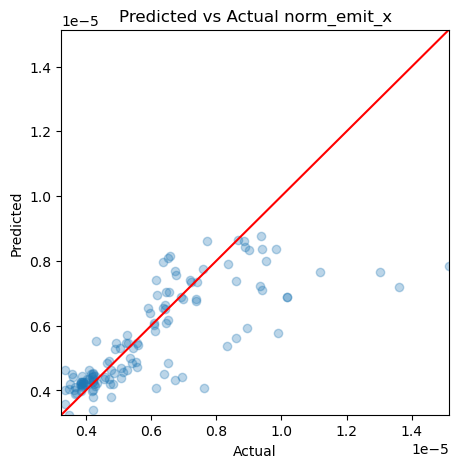

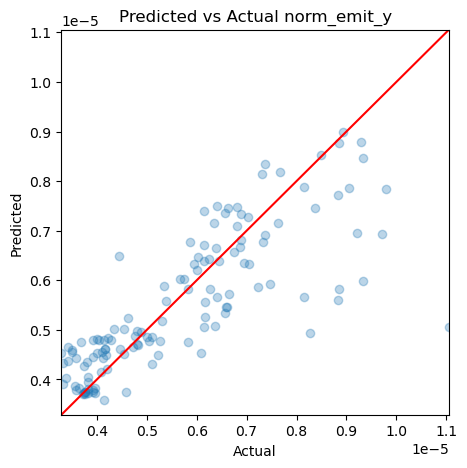

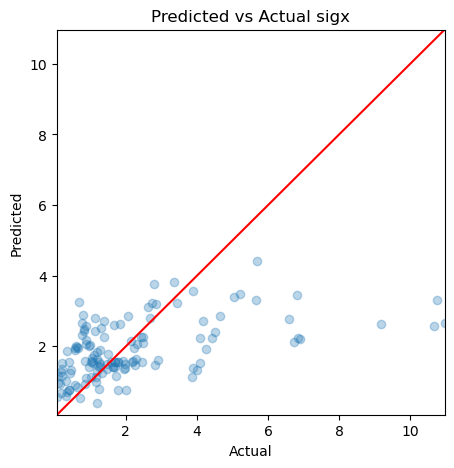

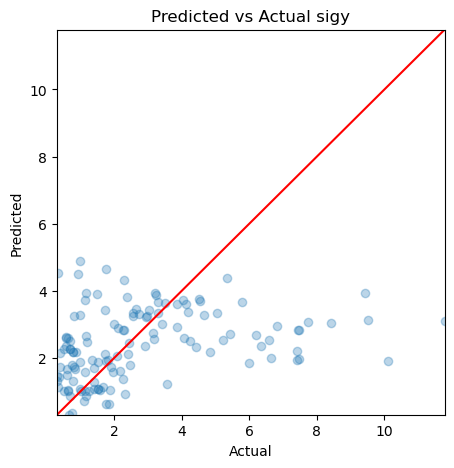

In [322]:
# calculate predictions
net.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data, target in test_dataloader:
        output = net(data)
        predictions.append(output.numpy())
        actuals.append(target.numpy())
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# inverse transform the data
# Assume `predictions_scaled` is a numpy array containing model predictions in the scaled form
predictions = scaler_targets.inverse_transform(predictions)
actuals = scaler_targets.inverse_transform(actuals)

# create scatter plots
for i, target in enumerate(targets):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals[:, i], predictions[:, i], alpha=0.3)
    plt.title(f'Predicted vs Actual {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    max_val = max(actuals[:, i].max(), predictions[:, i].max())
    min_val = min(actuals[:, i].min(), predictions[:, i].min())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Generate a grid of points
gun_phase_values = np.linspace(200, 300, 100)
sol_var_values = np.linspace(0.1, 0.3, 100)

# Transform variable range using the scaler for features
gun_phase_values_scaled = scaler_features.transform(np.array([[200, 0.2],[300, 0.2]]))[:,0]
sol_var_values_scaled = scaler_features.transform(np.array([[280, 0.1],[280, 0.3]]))[:,1]

gun_phase_values_scaled = np.linspace(gun_phase_values_scaled[0], gun_phase_values_scaled[1], 100)
sol_var_values_scaled = np.linspace(sol_var_values_scaled[0], sol_var_values_scaled[1], 100)

# Create an empty array to hold the predictions
predictions = np.zeros((100, 100, len(targets)))

# Predict the outputs for each point in the grid
for i, gun_phase in enumerate(gun_phase_values_scaled):
    for j, sol_var in enumerate(sol_var_values_scaled):
        input_features = torch.tensor([gun_phase, sol_var]).float().unsqueeze(0)
        prediction = net(input_features)
        predictions[i, j, :] = prediction.detach().numpy()

# Plot the predicted outputs
for target_idx, target in enumerate(targets):
    plt.figure(figsize=(10, 6))
    plt.contourf(gun_phase_values, sol_var_values, predictions[:, :, target_idx])
    plt.title(f"Predicted {target} for different phase and solenoid values")
    plt.xlabel('Phase')
    plt.ylabel('Solenoid')
    plt.colorbar(label=target)
    plt.show()


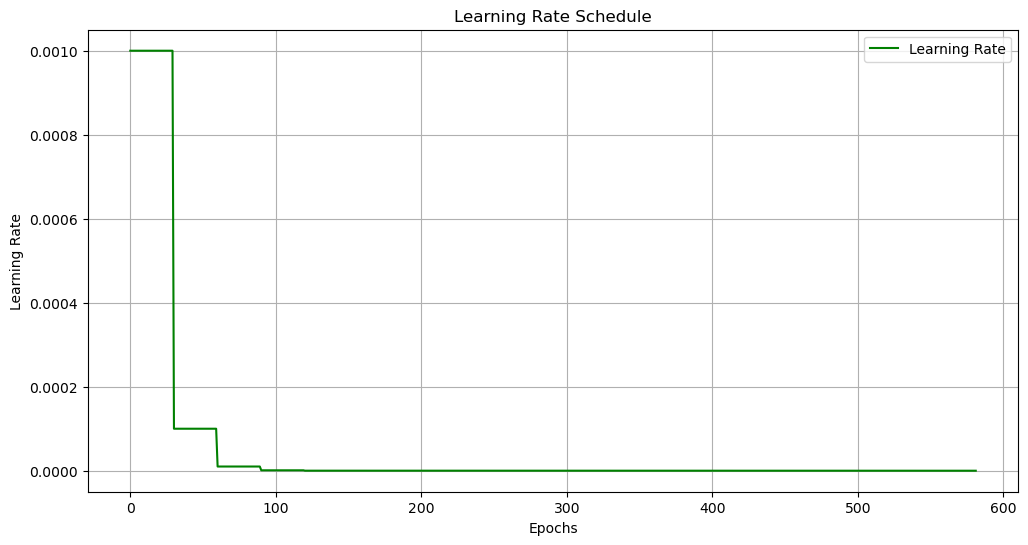

In [323]:
# Plotting the Learning Rate Schedule
plt.figure(figsize=(12,6))
plt.plot(learning_rates_extracted, label='Learning Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

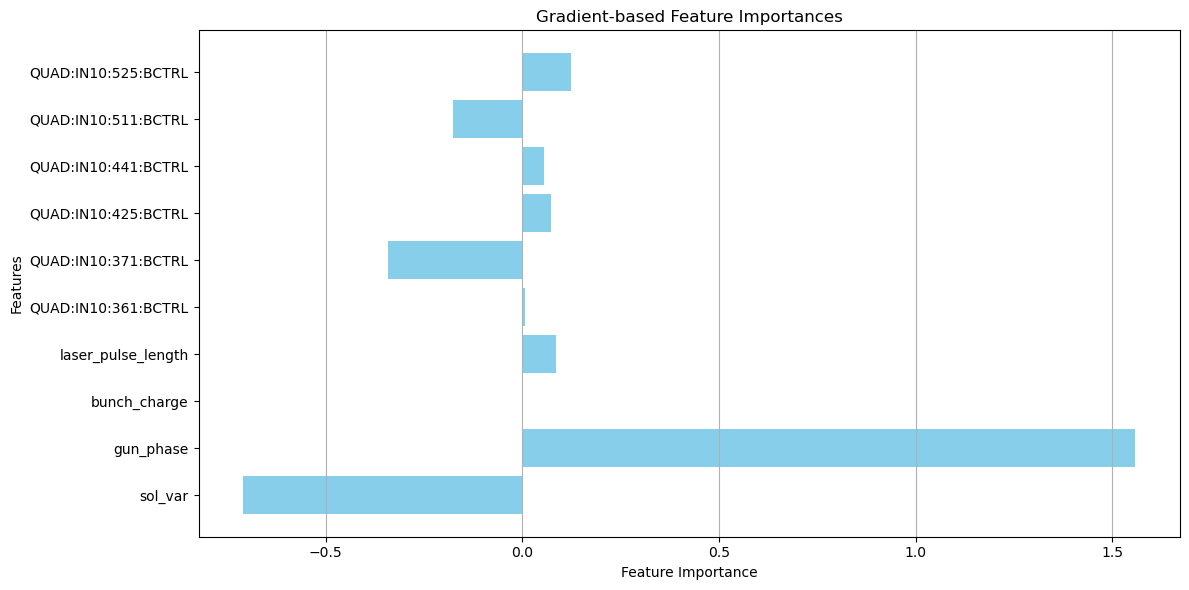

In [324]:
# 1. Pick a sample from the dataset
sample_input, sample_output = next(iter(train_dataloader))
sample_input.requires_grad = True  # Set requires_grad to True for computing gradient

# 2. Forward pass the sample through the model
net.eval()
predictions = net(sample_input)

# 3. Compute the gradient of the output with respect to the input features.
# We will consider the sum of the predictions to compute an aggregated importance.
predictions.sum().backward()

# 4. Extract the gradients (feature importances)
feature_importances = sample_input.grad.mean(dim=0).detach().numpy()

feature_importances

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Gradient-based Feature Importances")
plt.grid(axis='x')
plt.tight_layout()
plt.show()



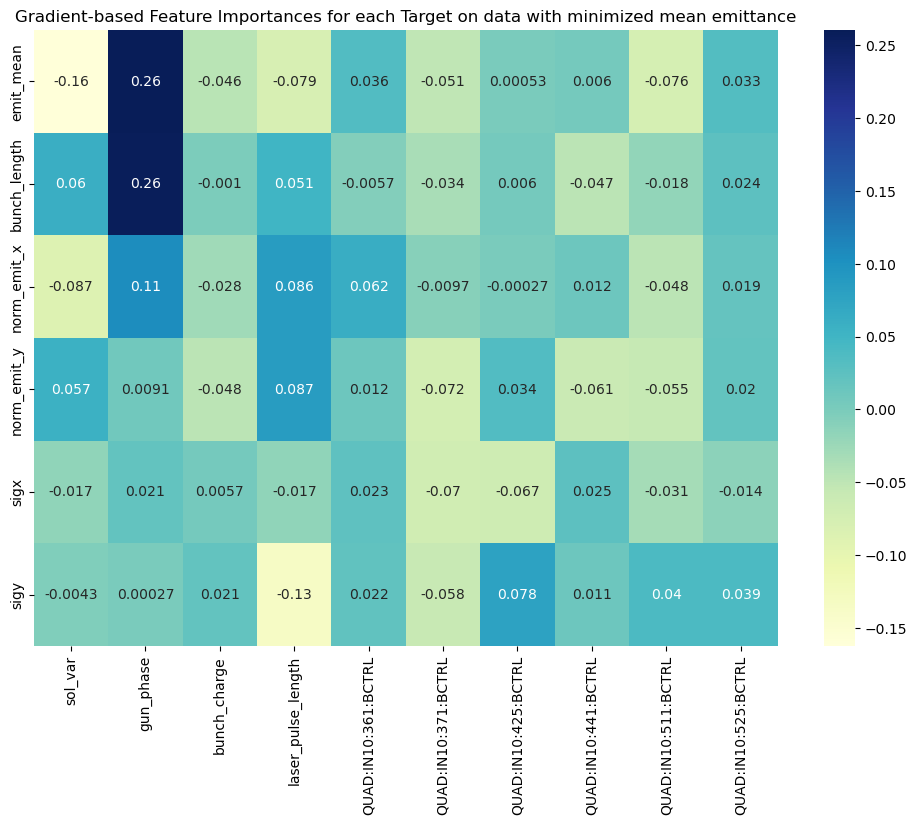

In [325]:
import seaborn as sns

# Sort the train_data by 'emit_mean' in ascending order
sorted_train_data = train_data.sort_values(by='emit_mean', ascending=True)

# Select the top batch of rows
selected_data = sorted_train_data.head(batch_size)

# Create TensorDataset and DataLoader for this batch
selected_dataset = TensorDataset(torch.tensor(selected_data[features].values).float(), torch.tensor(selected_data[targets].values).float())
selected_dataloader = DataLoader(selected_dataset, batch_size=batch_size, shuffle=False)

# Extract the batch
optimized_sample_input, _ = next(iter(selected_dataloader))

sample_input = optimized_sample_input
sample_input.requires_grad = True  # Set requires_grad to True for computing gradient


# Initialize a matrix to store the feature importances for each target
importance_matrix = np.zeros((len(targets), len(features)))

# Loop through each target
for target_idx, target in enumerate(targets):
    # Zero out gradients from previous iteration
    sample_input.grad = None
    
    # Forward pass the sample through the model
    predictions = net(sample_input)
    
    # Compute the gradient of the specific output with respect to the input features
    predictions[:, target_idx].sum().backward()
    
    # Extract the gradients (feature importances)
    feature_importances = sample_input.grad.mean(dim=0).detach().numpy()
    
    # Store the feature importances in the matrix
    importance_matrix[target_idx] = feature_importances

# Plot the matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(importance_matrix, xticklabels=features, yticklabels=targets, cmap="YlGnBu", annot=True)
plt.title("Gradient-based Feature Importances for each Target on data with minimized mean emittance")
plt.show()
